## generate adversary image 
This code is trying to generate adversary images based on MNIST classifier provided in Tensorflow Tutorial

### TensorFlow Tutorial  #1 (linear regression)

In [1]:
#import libraries
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
%matplotlib inline

 load the dataset as written in tutorial

In [2]:
#load mnist dataset
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#define placeholders
x_data = tf.placeholder(tf.float32, shape=[None, 784])
y_label = tf.placeholder(tf.float32, shape=[None, 10])

In [4]:
#linear regression model
def linear_model(epochs, batch_size,epsilon):
    #follow TensorFlow turtorial
    #linear regression model
    
    #declare variables
    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))
    
     #setup loss function, gradient step, prediction, accuravy etc. 
    pred = tf.matmul(x_data,W) + b
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=pred))
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #set flags to pick up images of digit two
    isDigitTwo = tf.equal(tf.argmax(pred,1), 2)
    isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
    isCorrectTwo_index = tf.where(isCorrectTwo)
    
    #define labels of digit two img
    two_label = [2]
    label_onehot_two = np.eye(10)[two_label]
    six_label = [6]
    label_onehot_six = np.eye(10)[six_label]
    
    #np array to store generated imgs and extracted imgs
    generated_imgs = np.zeros((10,784))
    extracted_two_imgs = np.zeros((10,784))
    
    with tf.Session() as sess:
        #initialize variables
        sess.run(tf.global_variables_initializer())

        #train the model
        for _ in range(epochs):
            batch = mnist_data.train.next_batch(batch_size)
            train_step.run(feed_dict={x_data: batch[0], y_label: batch[1]})

        #evaluate the model by accuracy
        print("Accuracy is:", accuracy.eval(feed_dict={x_data: mnist_data.test.images, y_label: mnist_data.test.labels}))
        
        #extract 10 samples of digit two images
        pred_two = sess.run(isCorrectTwo_index, feed_dict={x_data:mnist_data.test.images,y_label: mnist_data.test.labels})
        index_two = [item for sublist in pred_two.tolist() for item in sublist]
        for j in range(10):
            extracted_two_imgs[j] = mnist_data.test.images[index_two[j]]
        
        ### generate adversary images ###
        #get the gradient of image six
        # gradient = gradient of WX + b respect to X -> gradient =  W 
        W_var = sess.run(W)
        noise_six = epsilon * W_var[:,6]
        
        for i in range(10):
            generated_imgs[i] = noise_six + extracted_two_imgs[i] 
            pred_w = sess.run(pred,feed_dict={x_data:np.reshape(generated_imgs[i],(1,784))})
            pred_w_index = np.argmax(pred_w)
            print ('prediction: %d' %pred_w_index)
        
        return generated_imgs,extracted_two_imgs;
        
        
    

In [5]:
#run the model
gen_imgs,org_imgs = linear_model(20000,100,0.3)

Accuracy is: 0.9253
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6
prediction: 6


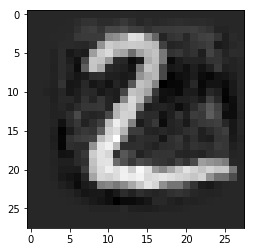

In [6]:
#visualize generated img
plt.imshow(np.reshape(gen_imgs[0],(28,28)), cmap='gray')

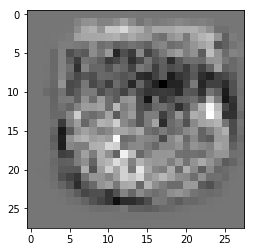

In [7]:
#visualize added weight
weight_added = gen_imgs - org_imgs
plt.imshow(np.reshape(weight_added[0],(28,28)),cmap='gray')

### TensorFlow Tutorial #2 (ConvNet)

In [8]:
#reshapre input data
x_image = tf.reshape(x_data, [-1, 28, 28, 1])

declare saver to save all parameter values after training

In [9]:
#functions for declare variables
def weight_variable(shape,name_):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name_)

def bias_variable(shape,name_):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial,name=name_)

#functions to define conv layer and pooling layes
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [10]:
#convnet model

#sess = tf.InteractiveSession()

#declare parameter values
W_conv1 = weight_variable([5, 5, 1, 32],"W_conv1")
b_conv1 = bias_variable([32],"b_conv1")
W_conv2 = weight_variable([5, 5, 32, 64],"W_conv2")
b_conv2 = bias_variable([64],"b_conv2")
W_fc1 = weight_variable([7 * 7 * 64, 1024],"W_fc1")
b_fc1 = bias_variable([1024],"b_fc1")
W_fc2 = weight_variable([1024, 10],"W_fc2")
b_fc2 = bias_variable([10],"b_fc2")

#declare saver to save all parameter values and retrieve it later
#saver = tf.train.Saver([W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2])

#first layer
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#second conv layer
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#flatten->fc layer->dropout
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#last layer
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#define loss func, gradient step, prediction
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy,var_list=[W_conv1, b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2])
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#define flags etc. to extract digit 2 images
isDigitTwo = tf.equal(tf.argmax(y_label,1), 2)
isCorrectTwo = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitTwo, tf.float32),tf.bool)
isCorrectTwo_index = tf.where(isCorrectTwo)

#also extract image of six
isDigitSix = tf.equal(tf.argmax(y_label,1), 6)
isCorrectSix = tf.cast(tf.cast(correct_prediction,tf.float32) * tf.cast(isDigitSix, tf.float32),tf.bool)
isCorrectSix_index = tf.where(isCorrectSix)

saver = tf.train.Saver(tf.global_variables()) #[W_conv1,b_conv1,W_conv2,b_conv2,W_fc1,b_fc1,W_fc2,b_fc2]

#declare list to store extracted images and counter
extracted_two_imgs = np.zeros((100,784))

#train, evaluate
with tf.Session() as sess:
    #initialize parameters
    sess.run(tf.global_variables_initializer())

    for i in range(1000): #20000
        batch = mnist_data.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x_data: batch[0], y_label: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x_data: batch[0], y_label: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
      x_data: mnist_data.test.images, y_label: mnist_data.test.labels, keep_prob: 1.0}))

    #save the current parameter values
    save_path = saver.save(sess,"./MNIST_weight/model_weight.ckpt")
    print('weight saved to %s' %save_path)

    #extract digit two
    pred_two = sess.run(isCorrectTwo_index, feed_dict={x_data:mnist_data.test.images,y_label: mnist_data.test.labels, keep_prob:1.0})
    index_two = [item for sublist in pred_two.tolist() for item in sublist]
    for j in range(100):
        extracted_two_imgs[j] = mnist_data.test.images[index_two[j]]
    print(j)
    
    #extract digit six
    pred_six = sess.run(isCorrectSix_index, feed_dict={x_data:mnist_data.test.images,y_label: mnist_data.test.labels, keep_prob:1.0})
    index_six = [item for sublist in pred_six.tolist() for item in sublist]
    extracted_six_img = mnist_data.test.images[index_six[0]]
    
    #pickle extracted imgs
    with open('./mnist_extract_imgs.p','wb') as f:
        pickle.dump([extracted_two_imgs,extracted_six_img],f)
    

step 0, training accuracy 0.06
step 100, training accuracy 0.82
step 200, training accuracy 0.94
step 300, training accuracy 0.98
step 400, training accuracy 0.98
step 500, training accuracy 0.96
step 600, training accuracy 0.9
step 700, training accuracy 0.96
step 800, training accuracy 0.92
step 900, training accuracy 1
test accuracy 0.9592
weight saved to ./MNIST_weight/model_weight.ckpt
99


### try to generate adversary images

try to generate adversary images by adding some noise to extracted image of digit 2. 
On writing this part, this link was really useful. [PASTE LINK LATER]

first, try to visualize extracted imgs

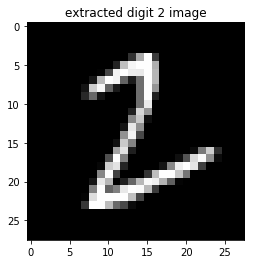

In [11]:
#visualize one of the samples in extracted_two_imgs
data = extracted_two_imgs[2]
plt.imshow(np.reshape(data,(28,28)),cmap='gray')
plt.title("extracted digit 2 image")

re-define parameters as untrainable and also define noise images as variable

generate new images by using the model weights

In [12]:
#generate new image 
#retrieve variables 
with open('./mnist_extract_imgs.p','rb') as f:
    extracted_two_imgs,extracted_six_img = pickle.load(f)

#define correct class and make it one-hot code
correct_class_two = [2]
correct_onehot_two = np.eye(10)[correct_class_two]
correct_class_six = [6]
correct_onehot_six = np.eye(10)[correct_class_six]

#re-define loss function etc.
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
gradient = tf.gradients(loss,x_data)
epsilon = 0.07 #same as panda one

#np array to store generated img
gen_imgs = np.zeros((100,784))#extracted_two_imgs

### generate
with tf.Session() as sess:
     #initialize all variables
    sess.run(tf.global_variables_initializer())
    
    #restore parameter valuers
    saver.restore(sess,"./MNIST_weight/model_weight.ckpt")
    print('model is restored')
    
   
    #for each image in extracted two, get gradient
    for i in range(100):
        
        #TODO: rewrite this part
        #the formula for added noise is:
        # n = epcilon * sign(gradient of loss respect to x)
        grad_img = sess.run(gradient, feed_dict={x_data:np.reshape(extracted_two_imgs[i],(1,784)), y_label:correct_onehot_two,keep_prob:1.0})
        noise =  epsilon * np.sign(grad_img) 
        gen_imgs[i] = noise + extracted_two_imgs[i]

        #printout prediction
        pred_wrong = sess.run(y_conv, feed_dict={x_data:np.reshape(gen_imgs[i],(1,784)),keep_prob:1.0})
        pred_id = np.argmax(pred_wrong)
        print ('prediction is: %d' %pred_id)
    
    n = gen_imgs - extracted_two_imgs

        

INFO:tensorflow:Restoring parameters from ./MNIST_weight/model_weight.ckpt
model is restored
prediction is: 2
prediction is: 2
prediction is: 3
prediction is: 4
prediction is: 2
prediction is: 3
prediction is: 7
prediction is: 2
prediction is: 2
prediction is: 8
prediction is: 2
prediction is: 9
prediction is: 3
prediction is: 2
prediction is: 3
prediction is: 3
prediction is: 2
prediction is: 0
prediction is: 8
prediction is: 3
prediction is: 2
prediction is: 2
prediction is: 3
prediction is: 1
prediction is: 3
prediction is: 2
prediction is: 2
prediction is: 1
prediction is: 2
prediction is: 3
prediction is: 2
prediction is: 2
prediction is: 7
prediction is: 1
prediction is: 6
prediction is: 1
prediction is: 1
prediction is: 2
prediction is: 2
prediction is: 0
prediction is: 2
prediction is: 0
prediction is: 7
prediction is: 2
prediction is: 3
prediction is: 2
prediction is: 1
prediction is: 1
prediction is: 7
prediction is: 2
prediction is: 8
prediction is: 2
prediction is: 1
predic

visualize noise images added

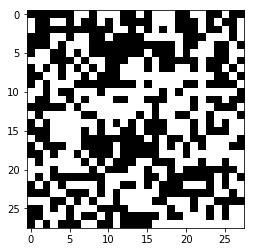

In [13]:
plt.imshow(np.reshape(n[0],(28,28)),cmap='gray')

visualize generated img

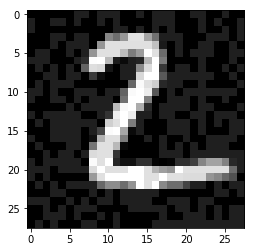

In [14]:
plt.imshow(np.reshape(gen_imgs[0],(28,28)),cmap='gray')